In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.evaluation import MulticlassMetrics,BinaryClassificationMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.functions import vector_to_array
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import NaiveBayes

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = spark.read.csv('gs://dataproc-staging-us-central1-881288578123-co6sg2sg/clear_csv/*.csv',header=False)
df = df.toDF('MONTH','DAY_OF_WEEK','OP_UNIQUE_CARRIER','ORIGIN','DEST','DEP_DELAY_NEW','ARR_DELAY_NEW','DISTANCE','DEP_TIME','ARR_TIME')
df = df.where(df.DISTANCE != 'DISTANCE')
df =df.withColumn("DISTANCE",col("DISTANCE").cast(IntegerType()))

In [3]:
indexers = [StringIndexer(inputCol="MONTH", outputCol="MONTH_index"), 
           StringIndexer(inputCol="DAY_OF_WEEK", outputCol="DAY_OF_WEEK_index"), 
           StringIndexer(inputCol="OP_UNIQUE_CARRIER", outputCol="OP_UNIQUE_CARRIER_index"), 
           StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_index"),
           StringIndexer(inputCol="DEST", outputCol="DEST_index"),
           StringIndexer(inputCol="DEP_DELAY_NEW", outputCol="DEP_DELAY_NEW_index"),
           StringIndexer(inputCol="ARR_DELAY_NEW", outputCol="label"),
           StringIndexer(inputCol="DEP_TIME", outputCol="DEP_TIME_index"),
           StringIndexer(inputCol="ARR_TIME", outputCol="ARR_TIME_index")
           ]

pipeline = Pipeline(stages=indexers)
indexed_df = pipeline.fit(df).transform(df)

In [4]:
vectorAssembler = VectorAssembler(inputCols = ["MONTH_index", "DAY_OF_WEEK_index", "OP_UNIQUE_CARRIER_index","ORIGIN_index","DEST_index","DEP_DELAY_NEW_index","DEP_TIME_index","ARR_TIME_index"],outputCol = "features")
vector_df = vectorAssembler.transform(indexed_df)

In [5]:
train_df, test_df = vector_df.randomSplit([0.7, 0.3], seed=42)

In [6]:
nb = NaiveBayes(modelType="multinomial")

In [10]:
nbmodel = nb.fit(train_df)

In [11]:
predictions = nbmodel.transform(test_df)

In [12]:
preds_and_labels = predictions.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

In [13]:
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[2580798. 1408685.]
 [ 867230. 1154497.]]


In [16]:
cf_matrix = metrics.confusionMatrix().toArray()

In [17]:
predictionAndLabels = predictions.select("prediction","label").rdd
multi_metrics = MulticlassMetrics(predictionAndLabels)
precision_score = multi_metrics.weightedPrecision
recall_score = multi_metrics.weightedRecall
accuracy_score = multi_metrics.accuracy
f1_score = multi_metrics.weightedFMeasure()

In [18]:
# Some metrics on our classified datas

print("Accuracy Score   : "+str(accuracy_score)) # Accuracy shows the percentage of the correct classifications with respect to all the samples
print("Precision Score  : "+str(precision_score)) # Precision is the ratio of the correctly positive labeled to all positive labeled : TP/(TP+FP)
print("Recall Score     : "+str(recall_score)) # Recall (or Sensitivity) is the ratio of the correctly positive labeled to all who are positive in reality : TP/(TP+FN)
print("F1 Score         : "+str(f1_score)) # F1-score is the harmonic mean (average) of precision and recall : 2*(Recall * Precision) / (Recall + Precision)

Accuracy Score   : 0.6213905503759648
Precision Score  : 0.648175925170116
Recall Score     : 0.6213905503759649
F1 Score         : 0.6299523391906292


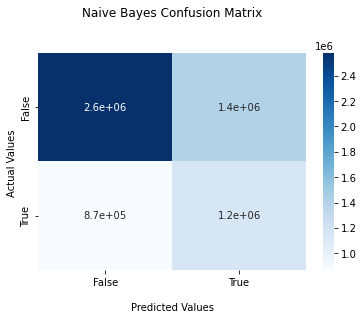

In [19]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Naive Bayes Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

# Display the visualization of the Confusion Matrix

plt.show()